# Playing Atari with Deep Reinforcement Learning

Paper: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

Walkthorugh: https://becominghuman.ai/lets-build-an-atari-ai-part-0-intro-to-rl-9b2c5336e0ec

# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import gym
import time
import json
from copy import deepcopy

import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from keras.callbacks import History
from keras.backend import tf as ktf
from keras.callbacks import Callback as KerasCallback, CallbackList as KerasCallbackList
from keras.callbacks import EarlyStopping, TensorBoard, CSVLogger
from keras.utils.generic_utils import Progbar
from keras.utils.vis_utils import model_to_dot

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy, Policy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import ModelIntervalCheckpoint, FileLogger

from IPython import display
from IPython.display import clear_output, SVG
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

# check our devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

class Visualizer(KerasCallback):
    def __init__(self, view_machine_mode=False, show_labels=True, save=False):
        self.machine_mode = view_machine_mode
        self.show_labels = show_labels
        self.save = save
    
    def _set_env(self, env):
        self.env = env
        self.img = plt.imshow(self.env.render(mode='rgb_array')) # only call this once
        self.frame = 0
        plt.figure(figsize = (10,10))

    def on_action_end(self, action, logs):
        """ Render environment at the end of each action """
        img = self.env.render(mode='rgb_array')
        
        if self.machine_mode:
            # This lines allow us to see what the NN sees
            img = img[::2, ::2] # downscale
            img = np.mean(img, axis=2).astype(np.uint8) # grayscale
        
        self.frame += 1
        plt.cla()
        plt.imshow(img)
        if self.show_labels:
            plt.annotate('frame : ' + str(self.frame), xy=(10, 40), color='white')
            plt.annotate('action: ' + str(action), xy=(10, 50), color='white')
            
        if not self.save:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            if not os.path.exists('dqn/frames/'):
                os.makedirs('dqn/frames')
            plt.savefig('dqn/frames/{0:05d}.png'.format(self.frame))
        
class AtariProcessor(Processor):      
    def process_observation(self, observation):
        # Normally, the observation is passed directly to the NN,
        # but we override this behavior to follow preprocessing steps
        img = observation 
        img = img[::2, ::2] # downscale
        img = np.mean(img, axis=2).astype(np.uint8) # grayscale
        return img

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13123642200171462714
]


In [2]:
env = gym.make('BreakoutDeterministic-v4') # try out different envs
env.reset()

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [3]:
with open('dqn/model_architecture.json') as f:
    model = model_from_json(f.read())
    
model.load_weights('dqn/weights.hdf5')
optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
frames (InputLayer)          (None, 4, 105, 80)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 4, 105, 80)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 25, 19)        4112      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 11, 32)         9760      
_________________________________________________________________
flatten_2 (Flatten)          (None, 2464)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               631040    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total para

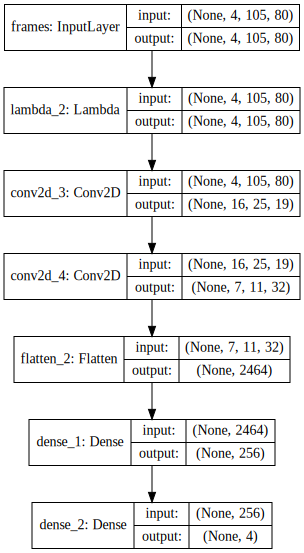

In [4]:
memory = SequentialMemory(limit=100000, window_length=4)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 'eps', 1., 0.1, 0., 100000)
dqn = DQNAgent(model=model, processor=AtariProcessor(), nb_actions=nb_actions, 
               memory=memory, nb_steps_warmup=50, target_model_update=1e-2, policy=policy, test_policy=policy)
dqn.compile(optimizer, metrics=['mse'])

model.summary()
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

In [ ]:
callbacks = []
callbacks = [Visualizer(save=True)]

test_hist = dqn.test(env, nb_episodes=1, action_repetition=4,
                     callbacks=callbacks, visualize=False)